In [35]:
# import os, sys
# sep = os.sep
# # Добавить в путь до родительской папки\n",
# sys.path.append(os.path.join(sys.path[0], f'..{sep}'))
# #sys.path.append(os.path.join(os.getcwd(), f'..{sep}'))

In [36]:
import os
#
import numpy as np
import matplotlib.pyplot as plt
#
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#
import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

%matplotlib inline

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 1 GANs to Generate Grayscale Images of Clothing Items

## 1.1 Training Samples and the Discriminator

In [38]:
torch.manual_seed(42)

transform = T.Compose([
    # Converts image pixels to PyTorch tensors
    # From range [0, 255] to range [0.0, 1.0]
    T.ToTensor(),
    # Normalizes the values to the range [–1.0, 1.0]
    # вычитаем 0.5 из данных и разделить разницу на 0.5
    T.Normalize([0.5], [0.5])
])

# Нормализация входных данных до диапазона [–1, 1]
# позволяет градиентному спуску работать более эффективно

In [39]:
train_set = torchvision.datasets.FashionMNIST( # Which dataset to download
    root='.',       # Where to save the data
    train=True,     # The training or test dataset
    download=True,  # Whether or not to download the data to your computer
    transform=transform  # Performs data transformation
)

'''
test_set = torchvision.datasets.FashionMNIST(
    root='.',
    train=False,     # The training or test dataset
    download=True,
    transform=transform
)
'''
pass

In [40]:
len(train_set)

60000

In [41]:
#print(train_set[0])
print(type(train_set[0]))

item_first = train_set[0]
# Тензор с нормированными пикселями
print(item_first[0].shape)
# Метка класса
print(item_first[1])

<class 'tuple'>
torch.Size([1, 28, 28])
9


In [42]:
# Ссылка на название меток для 10-ти классов https://github.com/pranay414/Fashion-MNIST-Pytorch 
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]

In [43]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

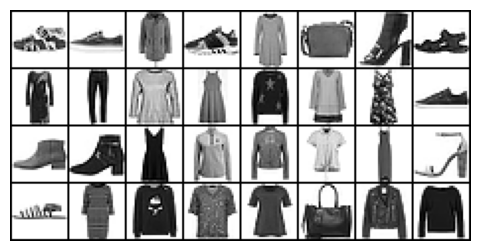

In [44]:
fig = plt.figure(figsize=(8, 3), dpi=100)
images, labels = next(iter(train_loader))

# Plot all the images of the 1st batch in grid
grid = make_grid(0.5 - images/2, nrow=8, padding=1)
plt.imshow(
    grid.numpy().transpose((1, 2, 0)),
    #cmap='binary'
    #cmap='gray'
    cmap='gray_r'
)
plt.axis('off')
plt.show();

In [45]:
# Discriminator D is binary classifier
D = nn.Sequential(
    # 784 = 28*28
    nn.Linear(784, 1024), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.3),
    nn.Linear(512, 256), nn.ReLU(),  nn.Dropout(0.3),
    nn.Linear(256, 1),
    # Сжать число на выходе до диапазона [0.0, 1.0]
    # 1 - образец реальный; 0 - образец поддельный
    nn.Sigmoid()
).to(device)

## 1.2 A Generator to Create Grayscale Images

In [46]:
# Генератор пытается минимизировать вероятность того, что
# поддельный образец будет идентифицирован как поддельный
G = nn.Sequential(
    # На входе будет вектор (случайного шума) длиной 100,
    # но изменение размерности на другие числа, например,
    # 500 или 1000, недолжно повлият на результаты.
    # Число 256 взято из последнего слоя дискриминатора!!!
    nn.Linear(100, 256), nn.ReLU(),
    # Второй слой генератора симметричен предпоследнему слою дискриминатора
    # (номера входов и выходов поменялись местами).
    nn.Linear(256, 512), nn.ReLU(),
    # Третий слой генератора симметричен третьему с конца слою дискриминатора.
    nn.Linear(512, 1024), nn.ReLU(),
    # Последний слой генератора симметричен первому слою дискриминатора
    # На выходе 784 = 28*28 пикселя 
    nn.Linear(1024, 784),
    # Сжать каждое число на выходе до диапазона [-1.0, 1.0]
    # - как у тренировочных данных
    nn.Tanh()
).to(device)

# За исключением входных значений генератора и выходного значения дискриминатора,
# все остальные полносвязные слои в генераторе зеркально отражают слои в дискриминаторе!

In [47]:
lr = 0.0001
optimD = torch.optim.Adam(D.parameters(), lr=lr)
optimG = torch.optim.Adam(G.parameters(), lr=lr)

# Loss Function for Discriminator and Generator (для Backpropagation)
# Binary cross-entropy loss function (Кросс-энтропия для бинарной классификации)
loss_fn = nn.BCELoss()

## 1.3 Train GANs to Generate Images of Clothing Items

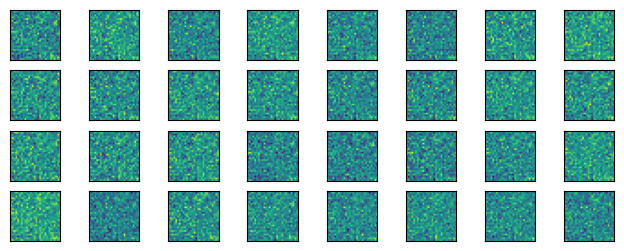

In [48]:
# Функция выводит 32 изображения, которые сгенерировал Generator
def see_output():
    fig = plt.figure(figsize=(8, 3), dpi=100)
    # Нормальное распределение с mean=1, std=1
    noise = torch.randn(batch_size, 100).to(device=device)

    # Generator генерирует данные
    # batch_size вектора, каждый длиной 784
    fake_samples = G(noise).cpu().detach()
    
    for i in range(batch_size):
        ax = plt.subplot(4, 8, i + 1)
        
        # fake_samples[i]/2 + 0.5: Числа из диапазона [-1.0, 1.0] переводим в диапазон [0.0, 1.0]
        # reshape(28, 28): Переводим в матрицу
        img = (fake_samples[i]/2 + 0.5).reshape(28, 28)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
see_output()

In [49]:
# Метки для истинных образцов
real_labels = torch.ones((batch_size, 1)).to(device)
# Метки для сгенерированных образцов
fake_labels = torch.zeros((batch_size, 1)).to(device)

In [50]:
# Один шаг тренировки Discriminator на истинных данных
def train_D_on_real(real_samples):
    # torch.Size([batch_size, 1, 28, 28]) => torch.Size([batch_size, 784])
    r = real_samples.reshape(-1, 28*28).to(device)
    # Работа дискриминатора (здесь он должен выдать вероятности близкие к 1)
    preds = D(r)

    labels1 = torch.ones((r.shape[0], 1)).to(device)

    # Backpropagation
    optimD.zero_grad()
    # labels1: Все 1
    loss_D = loss_fn(preds, labels1)    
    loss_D.backward()
    optimD.step()  # Изменяем веса дискриминатора
    
    return loss_D

In [51]:
# Один шаг тренировки Discriminator на сгенерированных данных
def train_D_on_fake():
    # Нормальное распределение с mean=1, std=1
    noise = torch.randn(batch_size, 100).to(device=device)
    # Generator генерирует данные
    fake_samples = G(noise)
    # Работа дискриминатора (здесь он должен выдать вероятности близкие к 0)
    preds = D(fake_samples)

    # Backpropagation
    optimD.zero_grad()
    # fake_labels: Все 0
    loss_D = loss_fn(preds, fake_labels)
    loss_D.backward()
    optimD.step()  # Изменяем веса дискриминатора
    
    return loss_D

In [52]:
# Один шаг тренировки Generator на сгенерированных данных
def train_G():
    # Нормальное распределение с mean=1, std=1
    noise = torch.randn((batch_size, 100))
    noise = noise.to(device)

    # Generator генерирует данные
    # Задача генератора обмануть дискриминатор
    # (чтобы он поддельные данные принял за истинные)
    fake_samples = G(noise)
    # Работа дискриминатора
    # Возвращает вероятности того, что сгенерированные
    # данные являются истинными
    out_G = D(fake_samples)

    # Backpropagation
    optimG.zero_grad()
    # real_labels: Все 1
    loss_G = loss_fn(out_G, real_labels)
    loss_G.backward()
    optimG.step()  # Изменяем веса генератора
    
    return loss_G, fake_samples

1, 2, 3, 4, 5, 6, 7, 8, 9, 
Epoch 10 => d_loss: 0.640050; g_loss 2.276485


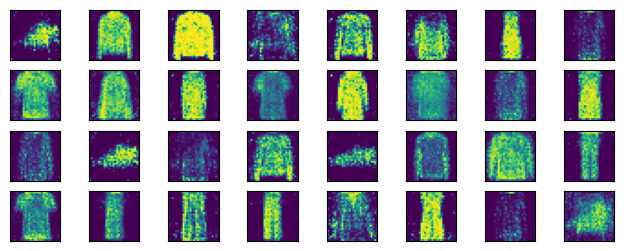

11, 12, 13, 14, 15, 16, 17, 18, 19, 
Epoch 20 => d_loss: 1.034923; g_loss 1.264972


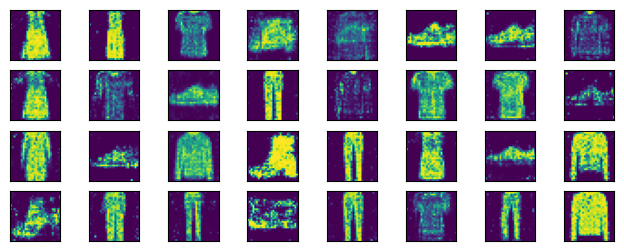

21, 22, 23, 24, 25, 26, 27, 28, 29, 
Epoch 30 => d_loss: 1.160682; g_loss 1.026984


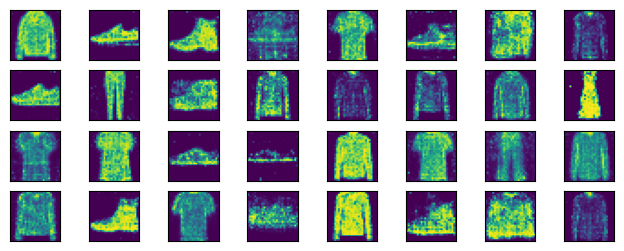

31, 32, 33, 34, 35, 36, 37, 38, 39, 
Epoch 40 => d_loss: 1.208277; g_loss 0.947549


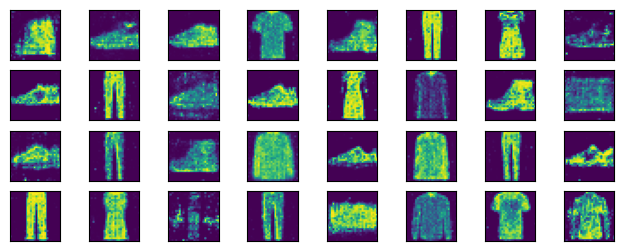

41, 42, 43, 44, 45, 46, 47, 48, 49, 
Epoch 50 => d_loss: 1.225136; g_loss 0.914680


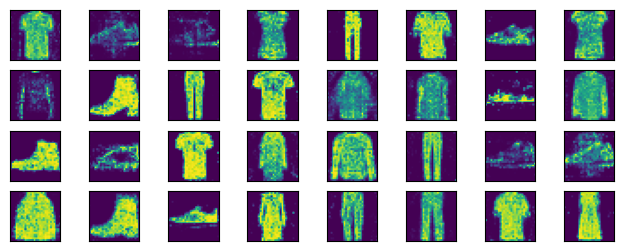

In [53]:
# Тренировка генератора
n_epoch = 50
for epoch in range(1, n_epoch+1):
    g_loss = 0
    d_loss = 0
    for n, (real_samples, _) in enumerate(train_loader):
        loss_D = train_D_on_real(real_samples)
        d_loss += loss_D
        loss_D = train_D_on_fake()
        d_loss += loss_D
        loss_G, fake_samples = train_G()
        g_loss += loss_G
    
    g_loss = g_loss/n
    d_loss = d_loss/n
    
    if epoch % 10 == 0:
        print()
        print(f"Epoch {epoch} => d_loss: {d_loss:.6f}; g_loss {g_loss:.6f}")
        see_output()
    else:
        print(epoch, end=', ')

In [54]:
# Save Trained Model
dir_name = 'files'
file_name = 'fashion_gen.pth'
os.makedirs(dir_name, exist_ok=True)

# Метод torch.jit.script() создает скрипт функции
# или класса nn.Module как код TorchScript
# с использованием компилятора TorchScript.
scripted = torch.jit.script(G) 
scripted.save(f'{dir_name}{os.sep}{file_name}')

In [55]:
# Load Trained Model
# Чтобы загрузить модель, даже не нужно ее определять. Просто загружаем сохраненный файл
new_G = torch.jit.load(f'{dir_name}{os.sep}{file_name}', map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
  (5): RecursiveScriptModule(original_name=ReLU)
  (6): RecursiveScriptModule(original_name=Linear)
  (7): RecursiveScriptModule(original_name=Tanh)
)

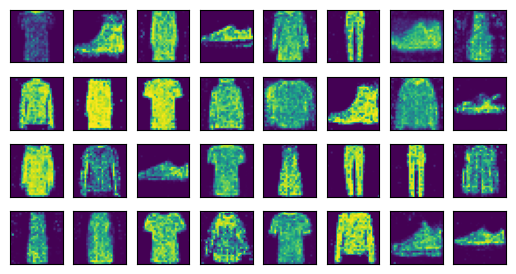

In [56]:
new_G.eval()
# Нормальное распределение с mean=1, std=1
noise = torch.randn(batch_size,100).to(device=device)
fake_samples = new_G(noise).cpu().detach()

for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    
    # fake_samples[i]/2 + 0.5: Числа из диапазона [-1.0, 1.0] переводим в диапазон [0.0, 1.0]
    # reshape(28, 28): Переводим в матрицу
    plt.imshow((fake_samples[i]/2 + 0.5).reshape(28, 28))
    plt.xticks([])
    plt.yticks([])

plt.subplots_adjust(hspace=-0.6)
plt.show();

# 2	Convolutional Layers

In [57]:
pass

## 2.1 How do convolutional operations work?

In [58]:
torch.manual_seed(42)

img = torch.Tensor([
    [1, 1, 1],
    [0, 1, 2],
    [8, 7, 6]
])

print(img.shape)
# Четыре значения в форме изображения (1, 1, 3, 3) — это количество изображений в пакете,
# количество цветовых каналов, высота изображения и ширина изображения соответственно.
img = img.reshape(1, 1, 3, 3)
print(img.shape)

torch.Size([3, 3])
torch.Size([1, 1, 3, 3])


In [66]:
conv = nn.Conv2d(
    # Количество каналов во входном изображении
    in_channels=1,
    # Количество каналов после сверточного слоя, которое может принимать любое число
    # в зависимости от того, сколько признаков вы хотите извлечь из изображения
    out_channels=1,
    # Размер ядра: например, kernel_size=3 означает, что фильтр имеет форму 3×3,
    # а kernel_size=4 означает, что фильтр имеет форму 4×4
    kernel_size=2, 
    # Аргумент шага указывает, на сколько пикселей нужно сместиться вправо или вниз
    # каждый раз, когда фильтр перемещается по входному изображению
    # default=1
    stride=1
)

sd = conv.state_dict()
sd

OrderedDict([('weight',
              tensor([[[[-0.2304, -0.0586],
                        [-0.2031,  0.3317]]]])),
             ('bias', tensor([-0.3947]))])

In [67]:
weights = {
    'weight': torch.tensor([[[
        [1, 2],
        [3, 4]
    ]]]),
   'bias': torch.tensor([0])
}
weights['weight'].shape

torch.Size([1, 1, 2, 2])

In [70]:
# Заменим веса и смещение целыми числами
for k in sd:
    print(k)
    with torch.no_grad():
        sd[k].copy_(weights[k])

conv.state_dict()

weight
bias


OrderedDict([('weight',
              tensor([[[[1., 2.],
                        [3., 4.]]]])),
             ('bias', tensor([0.]))])

In [71]:
print(img)
# Свертка
output = conv(img)
print(output)

# Как получили матрицу output
# 1*1 + 1*2 + 0*3 + 1*4 = 7
# 1*1 + 1*2 + 1*3 + 2*4 = 14
# 0*1 + 1*2 + 8*3 + 7*4 = 54
# 1*1 + 2*2 + 7*3 + 6*4 = 50

tensor([[[[1., 1., 1.],
          [0., 1., 2.],
          [8., 7., 6.]]]])
tensor([[[[ 7., 14.],
          [54., 50.]]]], grad_fn=<ConvolutionBackward0>)


## 2.2	How do stride and padding affect convolutional operations?

In [74]:
conv = nn.Conv2d(
    # Количество каналов во входном изображении
    in_channels=1,
    # Количество каналов после сверточного слоя, которое может принимать любое число
    # в зависимости от того, сколько признаков вы хотите извлечь из изображения
    out_channels=1,
    # Размер ядра: например, kernel_size=3 означает, что фильтр имеет форму 3×3,
    # а kernel_size=4 означает, что фильтр имеет форму 4×4
    kernel_size=2, 
    # Аргумент шага указывает, на сколько пикселей нужно сместиться вправо или вниз
    # каждый раз, когда фильтр перемещается по входному изображению
    # default=1
    stride=2,
    # Сколько строк\колонок с нулями добавить к четырем сторонам входного изображения,
    # default=0
    padding=1
)

sd = conv.state_dict()
# Заменим веса и смещение целыми числами
for k in sd:
    print(k)
    with torch.no_grad():
        sd[k].copy_(weights[k])

print(img)
# Свертка
# Если оставить stride=1, тогда за счет padding=1:
# размер изображения здесь будет  5×5 вместо 3×3
output = conv(img)
print(output)

# Как получили матрицу output
# 0*1 + 0*2 + 0*3 + 1*4 = 4
# 0*1 + 0*2 + 1*3 + 1*4 = 7
# 0*1 + 0*2 + 0*3 + 8*4 = 32
# 1*1 + 2*2 + 7*3 + 6*4 = 50

weight
bias
tensor([[[[1., 1., 1.],
          [0., 1., 2.],
          [8., 7., 6.]]]])
tensor([[[[ 4.,  7.],
          [32., 50.]]]], grad_fn=<ConvolutionBackward0>)


# 3	Transposed Convolution and Batch Normalization

In [75]:
pass

## 3.1 How do transposed convolutional layers work?

In [76]:
img = torch.Tensor([
    [1, 0],
    [2, 3]
])

# Четыре значения в форме изображения (1, 1, 2, 2) — это количество изображений в пакете,
# количество цветовых каналов, высота изображения и ширина изображения соответственно.
img = img.reshape(1, 1, 2, 2)
print(img.shape)

torch.Size([1, 1, 2, 2])


In [99]:
# Транспонированный сверточный слой
trans_conv = nn.ConvTranspose2d(
    in_channels=1,
    out_channels=1,
    kernel_size=2,
    # Управление объемом частоты дискретизации. Чем больше значение шага,
    # тем больше повышение частоты дискретизации 
    # default=1
    stride=2
)
sd = trans_conv.state_dict()

In [100]:
weights = {
    'weight': torch.tensor([[[
        [2, 3],
        [4, 5]
    ]]]),
    'bias':torch.tensor([0])
}
# Заменим веса и смещение целыми числами
for k in sd:
    print(k)
    with torch.no_grad():
        sd[k].copy_(weights[k])

trans_conv.state_dict()

weight
bias


OrderedDict([('weight',
              tensor([[[[2., 3.],
                        [4., 5.]]]])),
             ('bias', tensor([0.]))])

In [101]:
'''
Изображение представляет собой матрицу 2×2, фильтр также представляет собой матрицу 2×2.
Когда фильтр применяется к изображению, каждый элемент изображения умножается на фильтр
и отправляется на выход. Верхнее левое значение на изображении равно 1, умножаем его на
значения в фильтре, [[2, 3], [4, 5]], это приводит к четырем значениям в верхнем левом блоке 
выходной матрицы trans_output со значениями [[2, 3], [4, 5]].
Аналогично, нижнее правое значение на изображении равно 3, умножаем его на значения в фильтре,
[[2, 3], [4, 5]], это приводит к четырем значениям в нижнем правом блоке выходной матрицы
trans_output, [[6, 9], [12, 15]]
'''

print(img);
print(trans_conv.state_dict()['weight']); print()
trans_output = trans_conv(img)
print(trans_output)

tensor([[[[1., 0.],
          [2., 3.]]]])
tensor([[[[2., 3.],
          [4., 5.]]]])

tensor([[[[ 2.,  3.,  0.,  0.],
          [ 4.,  5.,  0.,  0.],
          [ 4.,  6.,  6.,  9.],
          [ 8., 10., 12., 15.]]]], grad_fn=<ConvolutionBackward0>)


In [110]:
# Комментарий лично для себя! Возможно понимаю неправильно...
# Если nn.Conv2d сворачиваеть изображение - изменяет его размеры
# То nn.ConvTranspose2d с теми же значениями - возвращаеть исходные размеры
# (если in_channels и out_channels поменять местам)

## 3.2 Batch Normalization

In [103]:
torch.manual_seed(42)
# Значения в диапазоне [0.0, 1.0)
img = torch.rand(1, 3, 64, 64)
# Четыре значения в форме изображения (1, 3, 64, 64) — это количество изображений в пакете,
# количество цветовых каналов, высота изображения и ширина изображения соответственно.
img.shape

torch.Size([1, 3, 64, 64])

In [106]:
conv = nn.Conv2d(
    # Количество каналов во входном изображении
    in_channels=3,
    # Количество каналов после сверточного слоя, которое может принимать любое число
    # в зависимости от того, сколько признаков вы хотите извлечь из изображения
    out_channels=3,
    # Размерм ядра: например, kernel_size=3 означает, что фильтр имеет форму 3×3
    kernel_size=3, 
    # Аргумент шага указывает, на сколько пикселей нужно сместиться вправо или вниз
    # каждый раз, когда фильтр перемещается по входному изображению
    # default=1
    stride=1,
    # Сколько строк\колонок с нулями добавить к четырем сторонам входного изображения,
    # default=0
    padding=1
)
# Свертка
out = conv(img)
print(img.shape, out.shape)

torch.Size([1, 3, 64, 64]) torch.Size([1, 3, 64, 64])


In [107]:
# mean и std по каждому из трех каналов
for i in range(3):
    print(f'mean in channel {i} is', out[:, i, :, :].mean().item())
    print(f'std in channel {i} is', out[:, i, :, :].std().item())

mean in channel 0 is 0.25408294796943665
std in channel 0 is 0.1798543781042099
mean in channel 1 is -0.2502423822879791
std in channel 1 is 0.13218806684017181
mean in channel 2 is -0.18939433991909027
std in channel 2 is 0.19904986023902893


In [108]:
# Нормализация выполняется независимо для каждого канала признаков
# путем корректировки и масштабирования значений в канале таким образом,
# чтобы они имели среднее значение 0 и дисперсию 1
norm = nn.BatchNorm2d(3)
out2 = norm(out)
print(out2.shape)

# mean и std по каждому из трех каналов
for i in range(3):
    print(f'mean in channel {i} is', out2[:, i, :, :].mean().item())
    print(f'std in channel {i} is', out2[:, i, :, :].std().item())

torch.Size([1, 3, 64, 64])
mean in channel 0 is -4.516914486885071e-08
std in channel 0 is 0.9999675154685974
mean in channel 1 is -4.0046870708465576e-08
std in channel 1 is 0.9998359680175781
mean in channel 2 is 3.725290298461914e-09
std in channel 2 is 0.9999958276748657
